In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from plotly.offline import iplot
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
retail_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/dataset-3.csv",delimiter=",")
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010/12/1 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010/12/1 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010/12/1 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010/12/1 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010/12/1 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011/12/9 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011/12/9 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011/12/9 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011/12/9 12:50,4.15,12680.0,France


### Preprocessing  
There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [28]:
#remove some of descriptions have spaces.
retail_df['Description'] = retail_df['Description'].str.strip()

#remove NA values
retail_df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

#remove cancelled orders
retail_df['InvoiceNo'] = retail_df['InvoiceNo'].astype('str')
retail_df = retail_df[~retail_df['InvoiceNo'].str.contains('C')]

In [29]:
# choose country
# retail_df_france = retail_df[retail_df['Country'] == 'France']
retail_df_france = retail_df

### RFM Segmentation
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did.

Recency (R) of a customer: Days since the last purchase.  
Frequency (F) of the bookings/turnover of a customer, e.g. Number of purchases in 6 months.  
Monetary (M) - The total turnover of a customer, e.g. Sum of sales in 6 months.  

Recency 反應的是顧客的活躍度  
Frequency 能幫你找到持續購物的顧客  
Monetary 幫你分辨真正的「貴客」  

In [30]:
# Monetary
retail_df_france['Monetary'] = retail_df_france['Quantity'] * retail_df_france['UnitPrice']

#caculate total Monetary of each custoner
Monetary_df = retail_df_france.groupby('CustomerID')['Monetary'].sum()
Monetary_df = Monetary_df.reset_index()
Monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [31]:
# caculate recency of each customer
# convert to datetime
retail_df_france['InvoiceDate'] = pd.to_datetime(retail_df_france['InvoiceDate'],format='%Y-%m-%d %H:%M')

# compute the max date,That is, the most recent consumption date
max_date = max(retail_df_france['InvoiceDate'])

# compute the diff
retail_df_france['diff'] = max_date - retail_df_france['InvoiceDate']
# only use the number of day
retail_df_france['diff'] = retail_df_france['diff'].dt.days

# recency
recency_df = retail_df_france.groupby('CustomerID')['diff'].min()
recency_df = recency_df.reset_index()
recency_df.head()

,CustomerID,diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [32]:
# frequency
# Some data sets only have invoices but do not show customers

Cust_freq = retail_df_france[['InvoiceNo','CustomerID']].drop_duplicates()

#Calculating the count of unique purchase for each customer
frequency_df = Cust_freq.groupby(['CustomerID'])['InvoiceNo'].aggregate('count')
frequency_df = frequency_df.reset_index()
frequency_df.columns = ['CustomerID', 'frequency']
frequency_df.head()

,CustomerID,frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [33]:
#merge dataframe
df1 = pd.merge(recency_df,frequency_df)
rfm_df = pd.merge(df1,Monetary_df)

rfm_df.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm_df

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4334,18280.0,277,1,180.60
4335,18281.0,180,1,80.82
4336,18282.0,7,2,178.05
4337,18283.0,3,16,2094.88


### Normaize data
Normalizing dataset so that each metric (Recency, Frequency, and Monetary) is from the same scale.  
Without standardization, the clustering algorithm could be biased since Monetary might be much higher than the other two variables

In [35]:
rfm_standard = MinMaxScaler().fit_transform(rfm_df)
# convey array to dataframe and set columns,index
rfm_standard = pd.DataFrame(data = rfm_standard , index = rfm_df.index, columns = rfm_df.columns)
rfm_standard = rfm_standard.drop(['CustomerID'],axis=1)
rfm_standard

,Recency,Frequency,Monetary
0,0.871314,0.000000,0.275453
1,0.002681,0.028708,0.015382
2,0.198391,0.014354,0.006414
3,0.048257,0.000000,0.006272
4,0.828418,0.000000,0.001193
...,...,...,...
4334,0.742627,0.000000,0.000645
4335,0.482574,0.000000,0.000288
4336,0.018767,0.004785,0.000635
4337,0.008043,0.071770,0.007476


### K-means algorithm for clustering

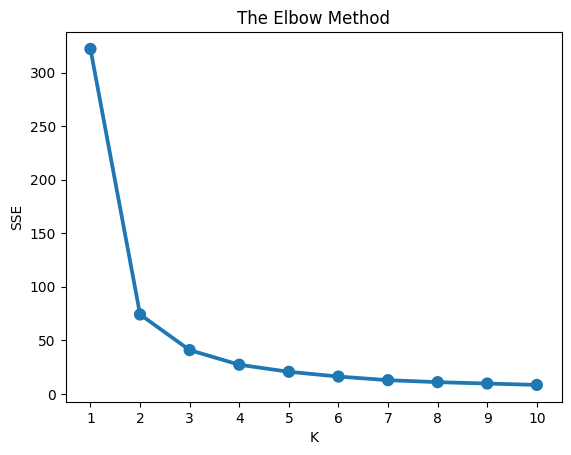

In [14]:
#use elbow method to determine the number of clustering


#fit KMeans and calculate SSE for each K
sse = []
for k in range(1,11):
	kmeans = KMeans(n_clusters = k, random_state=1)
	kmeans.fit(rfm_standard)
	sse.append(kmeans.inertia_)

#plot SSE for each K
plt.title('The Elbow Method')
plt.xlabel('K'); plt.ylabel('SSE')
sns.pointplot(x= list(range(1,11)) , y = sse)
plt.show()

Silhouette score for number of cluster(s) 2: 0.7225715615562703
Silhouette score for number of cluster(s) 3: 0.6450110338765475
Silhouette score for number of cluster(s) 4: 0.5619856959077197
Silhouette score for number of cluster(s) 5: 0.5507828057451986
Silhouette score for number of cluster(s) 6: 0.5672738654046748
Silhouette score for number of cluster(s) 7: 0.5393312822104316
Silhouette score for number of cluster(s) 8: 0.47051732263375146
Silhouette score for number of cluster(s) 9: 0.4869922854555314
Silhouette score for number of cluster(s) 10: 0.485004667926085
Silhouette score for number of cluster(s) 11: 0.49962574877711224


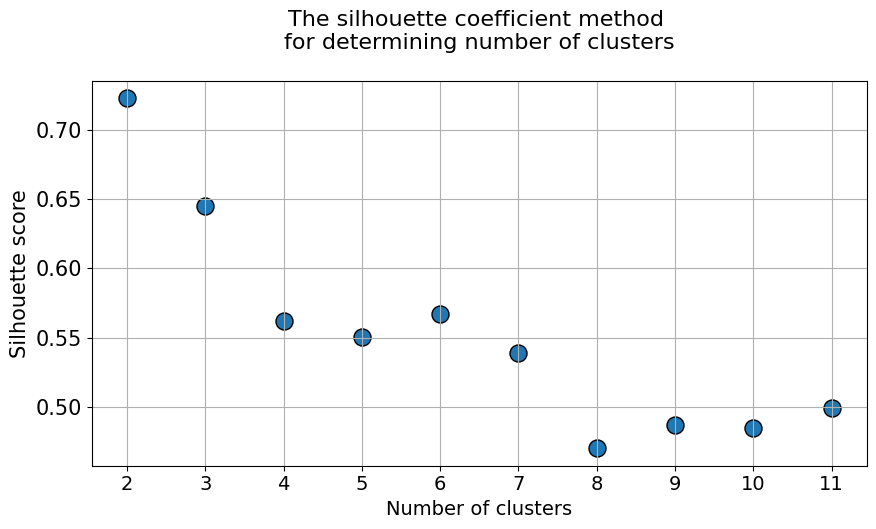

In [15]:
wcss_silhouette = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(rfm_standard)
    preds = km.predict(rfm_standard)
    silhouette = silhouette_score(rfm_standard,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

### Fit k-means model

In [16]:
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(rfm_standard)
#extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

cluster_rfm_df = rfm_standard.assign(Cluster = cluster_labels)
cluster_rfm_df

,Monetary,Recency,Frequency,Cluster
0,0.275453,0.871314,0.000000,1
1,0.015382,0.002681,0.028708,0
2,0.006414,0.198391,0.014354,2
3,0.006272,0.048257,0.000000,0
4,0.001193,0.828418,0.000000,1
...,...,...,...,...
4334,0.000645,0.742627,0.000000,1
4335,0.000288,0.482574,0.000000,3
4336,0.000635,0.018767,0.004785,0
4337,0.007476,0.008043,0.071770,0


### Visualize clustering results

Text(0.5, 0.5, 'Frequency')

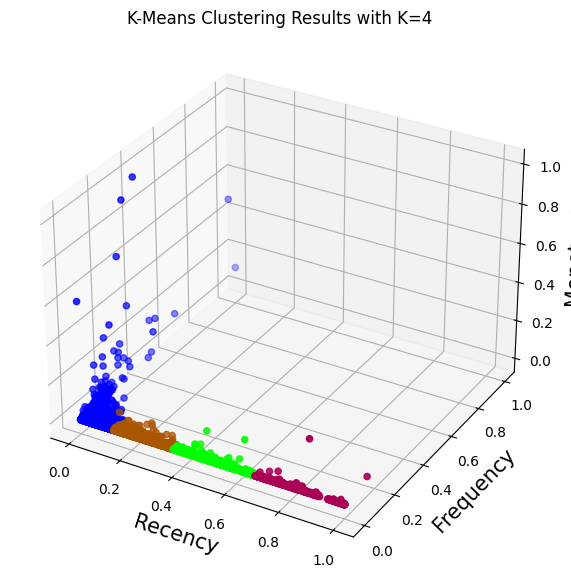

In [17]:
fig=plt.figure()
fig.set_size_inches(9, 7)
ax =fig.add_subplot(111,projection='3d')
ax.set_title('K-Means Clustering Results with K=4')
ax.scatter(cluster_rfm_df['Recency'],cluster_rfm_df['Frequency'], cluster_rfm_df['Monetary'] ,cmap='brg',c=cluster_rfm_df['Cluster']);
ax.set_zlabel(r'Monetary', fontsize=15)
plt.xlabel('Recency',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

In [18]:
fig = px.scatter_3d(cluster_rfm_df, x='Recency',y='Frequency', z='Monetary',color='Cluster')
iplot(fig)

In [19]:
#summary of clustering results
rfm_df['Cluster'] = cluster_rfm_df['Cluster']
summary = rfm_df.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
    })
summary

Recency Frequency     Monetary      
               mean      mean         mean count
Cluster                                         
0         18.194744  6.489911  3311.583642  2131
1        307.867470  1.349398   565.829056   498
2         79.760331  2.637282  1030.357137  1089
3        190.254428  1.871176   725.573866   621

## RFM result analysis
* Customer in cluster 0 has highest frequency & monetary value with least recency. These are 'Best Customers'

* Customer in cluster 2 has High frequency & monetary value with good recency
These are 'Loyal Customers'. They should be entered in the Loyalty Program and given special benefits.

* Customer in cluster 3 has Medium monetary, recency and frequency values. these are 'Occasional Customers'.We should be sent more promos and offers.

* Customer's in cluster 1 has shopped long ago who used to shop a lot. These are 'Almost Lost'. We don't need to pay much attention, May be some targeted offers can bring them back to shopping


In [24]:
rfm_df["Segment"] = rfm_df["Cluster"]
rfm_df["Segment"] = rfm_df["Segment"].replace({0:'Best Customers'})
rfm_df["Segment"] = rfm_df["Segment"].replace({2:'Loyal Customers'})
rfm_df["Segment"] = rfm_df["Segment"].replace({3:'Occasional Customers'})
rfm_df["Segment"] = rfm_df["Segment"].replace({1:'Almost Lost Customers'})
rfm_df['Country'] = retail_df_france.groupby('CustomerID')['Country'].max().values
rfm_df

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment,Country
0,12346.0,325,1,77183.60,1,Almost Lost Customers,United Kingdom
1,12347.0,1,7,4310.00,0,Best Customers,Iceland
2,12348.0,74,4,1797.24,2,Loyal Customers,Finland
3,12349.0,18,1,1757.55,0,Best Customers,Italy
4,12350.0,309,1,334.40,1,Almost Lost Customers,Norway
...,...,...,...,...,...,...,...
4334,18280.0,277,1,180.60,1,Almost Lost Customers,United Kingdom
4335,18281.0,180,1,80.82,3,Occasional Customers,United Kingdom
4336,18282.0,7,2,178.05,0,Best Customers,United Kingdom
4337,18283.0,3,16,2094.88,0,Best Customers,United Kingdom


In [ ]:
rfm_df.to_csv('rfm_v3.csv',index = False)